In [89]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Flatten

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    if filenames:
        train_csv = os.path.join(dirname, filenames[2])
        test_csv = os.path.join(dirname, filenames[1])
        submission_csv = os.path.join(dirname, filenames[0])

print(train_csv)
print(test_csv)
print(submission_csv)

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [90]:
df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(test_csv)
df_submmision = pd.read_csv(submission_csv)

In [91]:
batch_size = 128
num_epoches = 30
val_split = 0.15
input_shape = (32, 32, 3)
padding = ((0, 0), (2,2), (2,2), (0, 0))

MobileNet only expect 3 channel images with minimum size with 32 * 32. So pad images and stack along channel dimension

In [92]:
def preprocess_data(Xinput):    
    Xinput = Xinput / 255.0
    Xinput = Xinput.reshape(-1,28,28)

    Xinput = np.dstack([Xinput] * 3)
    Xinput = Xinput.reshape(Xinput.shape[0], 28, 28, 3)
    Xinput = np.pad(Xinput, padding, 'constant')
    return Xinput

In [93]:
df_cols = df_train.columns.values
Xtrain = df_train[df_cols[1:]].values
Ytrain = df_train[df_cols[0]].values

Xtest = df_test[df_test.columns.values].values
Xtrain = preprocess_data(Xtrain)
Xtest = preprocess_data(Xtest)

Xtrain,Ytrain = shuffle(Xtrain,Ytrain)
print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)

(42000, 32, 32, 3)
(28000, 32, 32, 3)
(42000,)


In [94]:
from tensorflow.keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

In [95]:
def classifier():
    mobilenet_functional = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    inputs = Input(shape=input_shape)
    x = inputs
    for layer in mobilenet_functional.layers[1:-1]:
        layer.trainable = False
        x = layer(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(
                inputs=inputs,
                outputs=outputs
            )
    
    model.compile(
                  optimizer='Adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', f1_score]
                  )
    history = model.fit(
                  Xtrain,
                  Ytrain,
                  batch_size = batch_size,
                  validation_split = val_split,
                  epochs=num_epoches
                    )
    return history, model

In [96]:
def plot_metrics(history):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    
    loss_train = np.cumsum(loss_train) / np.arange(1,num_epoches+1)
    loss_val = np.cumsum(loss_val) / np.arange(1,num_epoches+1)
    plt.plot(loss_train, 'r', label='Training loss')
    plt.plot(loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_train = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    
    plt.plot(acc_train, 'r', label='Training loss')
    plt.plot(acc_val, 'b', label='validation loss')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    f1_score_train = history.history['f1_score']
    f1_score_val = history.history['val_f1_score']
    
    plt.plot(f1_score_train, 'r', label='Training loss')
    plt.plot(f1_score_val, 'b', label='validation loss')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/30
279/279 [==============================] - 4s 14ms/step - loss: 0.4611 - accuracy: 0.8525 - f1_score: 1.6424 - val_loss: 0.5810 - val_accuracy: 0.8300 - val_f1_score: 1.2779
Epoch 2/30
279/279 [==============================] - 3s 10ms/step - loss: 0.2663 - accuracy: 0.9128 - f1_score: 1.1910 - val_loss: 0.3110 - val_accuracy: 0.9078 - val_f1_score: 1.1769
Epoch 3/30
279/279 [==============================] - 3s 11ms/step - loss: 0.2289 - accuracy: 0.9247 - f1_score: 1.1588 - val_loss: 0.2257 - val_accuracy: 0.9275 - val_f1_score: 1.1309
Epoch 4/30
279/279 [==============================] - 3s 10ms/step - loss: 0.1988 - accuracy: 0.9342 - f1_score: 1.1333 - val_loss: 0.2412 - val_accuracy: 0.9262 - val_f1_score: 1.1196
Epoch 5/30
279/279 [==============================] - 3s 12ms/step - loss: 0.1784 - accuracy: 0.9405 - f1_score: 1.1197 - val_loss: 0.2285 - val_accuracy: 0.9287 - val_f1_score: 1.1144
Epoch 6/30
279/279 [==============================] - 3s 11ms/step - loss: 

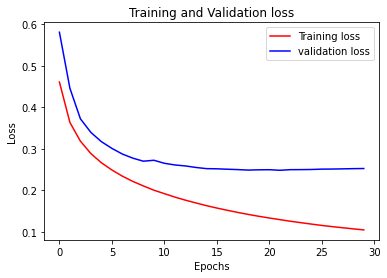

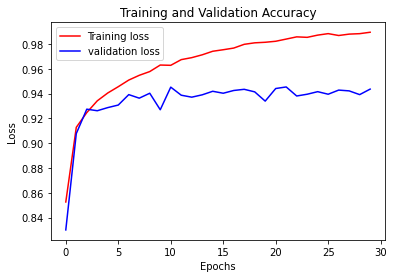

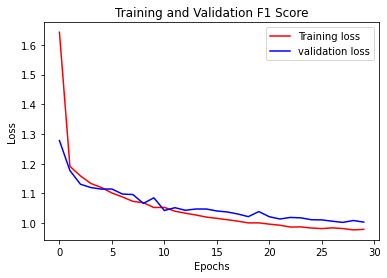

In [97]:
history, model = classifier()
plot_metrics(history)

**Predictions**

In [98]:
P = model.predict(Xtest)
Ypred = P.argmax(axis=-1).astype(int)

In [99]:
df_submmision['Label'] = Ypred
df_submmision.head()

,ImageId,Label
0,1,2
1,2,0
2,3,5
3,4,2
4,5,3


In [100]:
submission_path = '/kaggle/working/mnist_mobilenet.csv'
df_submmision.to_csv(submission_path)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/output/kaggle/working/mnist_mobilenet.csv'